# Schematic

In [6]:
# 999-C1

# Standard library imports
import sys
from datetime import datetime
from time import process_time
pt0 = process_time()
from time import time as wall_clock
wc0 = wall_clock()

# Third-Party Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy

import xarray

# Local imports
import pystare

# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6

n_legend_colors = 8
LEGEND_COLORS = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))

km = 1

# 10 Colors
# LEGEND_COLORS = list(mcolors.TABLEAU_COLORS)

# 8 Colors
# LEGEND_COLORS = list(mcolors.BASE_COLORS)

# 148 Colors
#LEGEND_COLORS = list(mcolors.CSS4_COLORS)

# 949 Colors
# LEGEND_COLORS = list(mcolors.XKCD_COLORS)

# Define Classes and Functions
# ----------------------------

def divert_stderr():
    sys.stderr = open('stderr.out', 'w')
    return


def restore_stderr(_verbose=None):
    _verbose = (True if _verbose is None else _verbose)
    sys.stderr.close()
    if _verbose:
        with open('stderr.out') as f:
            count = sum(1 for _ in f)
        if count > 0:
            print(f"{count} warnings or errors encountered while stderr diverted. See stderr.out")
    sys.stderr = sys.__stderr__
    return


class FigAxContainer:
    def __init__(self, figax):
        self.fig = figax[0]  # class 'matplotlib.figure.Figure'
        self.ax = figax[1]   # class 'cartopy.mpl.geoaxes.GeoAxesSubplot'
        return


def add_coastlines(figax, set_global=None):
    """Add coastlines to the plot."""
    set_global = (False if set_global is None else set_global)
    if set_global:
        figax.ax.set_global()
    figax.ax.add_feature(cf.COASTLINE, linewidth=0.5, edgecolor='k')
    return figax


def hello_plot(spatial_index_values=None
               , figax=None, plot_options=None, set_global=None, set_coastlines=None
               , show_fig=None, color=None, lw=None, legend_label=None, use_dash=None
               , bbox_to_anchor=None
               , verbose=None
               , rasterized=None
              ):
    
    spatial_index_values = (None if spatial_index_values is None else spatial_index_values)
    figax = (None if figax is None else figax)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    set_global = (False if set_global is None else set_global)
    set_coastlines = (True if set_coastlines is None else set_coastlines)
    show_fig = (True if show_fig is None else show_fig)
    color = (None if color is None else color)
    lw = (1 if lw is None else lw)
    legend_label = (None if legend_label is None else legend_label)
    use_dash = (None if use_dash is None else use_dash)
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    verbose = (True if verbose is None else verbose)
    rasterized = (True if rasterized is None else rasterized)

    if figax is None:
        # Initialize the FigAxContainer the first time it is used
        figax = FigAxContainer(plt.subplots(1, subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()

    if spatial_index_values is not None:
        if isinstance(spatial_index_values,xarray.Dataset):
            lons = spatial_index_values.lons.data.reshape(3*len(spatial_index_values.htm))
            lats = spatial_index_values.lats.data.reshape(3*len(spatial_index_values.htm))
            intmat = spatial_index_values.intmat.data
        else:
            # Calculate vertices and interconnection matrix
            lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons, lats, intmat)

        divert_stderr()
        if use_dash is not None:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw,
                             label="Placeholder", dashes=use_dash, rasterized=rasterized)            
        else:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw, 
                             label="Placeholder", rasterized=rasterized)
        restore_stderr(_verbose=verbose)
 
        # Add Legend
        if legend_label is not None:
            if isinstance(legend_label, list):
                # plt.triplot produces two legend entries. 
                #  The first of those are the edges
                #  The second contains the points (nodes).
                bbox_to_anchor = ( (1.7,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                the_handels, the_labels = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=the_handels[::2], labels=legend_label, bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False) 
            elif isinstance(legend_label, str):
                bbox_to_anchor = ( (1.4,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                h, l = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=[h[0]], labels=[legend_label], bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False)

    if show_fig:
        # Show figure now
        plt.show()

    return figax

def hex16(ival):
    return "0x%016x" % ival

def labeled_plot(sivs,figax,plot_labels=True
                 , bbox_to_anchor=None
                 , plot_options=None
                 , rasterized = None
                ):
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    rasterized = ( True if rasterized is None else rasterized )
    
    # Plot each increment (overlay on common axes)
    legend_info = []
    n_legend_colors = len(sivs)
    legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
    
    for siv_idx, siv in enumerate(sivs):
        
        legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
        the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
        the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
        if len(legend_info[0]) < 32 or not plot_labels:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
        else:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False
                       , lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
            



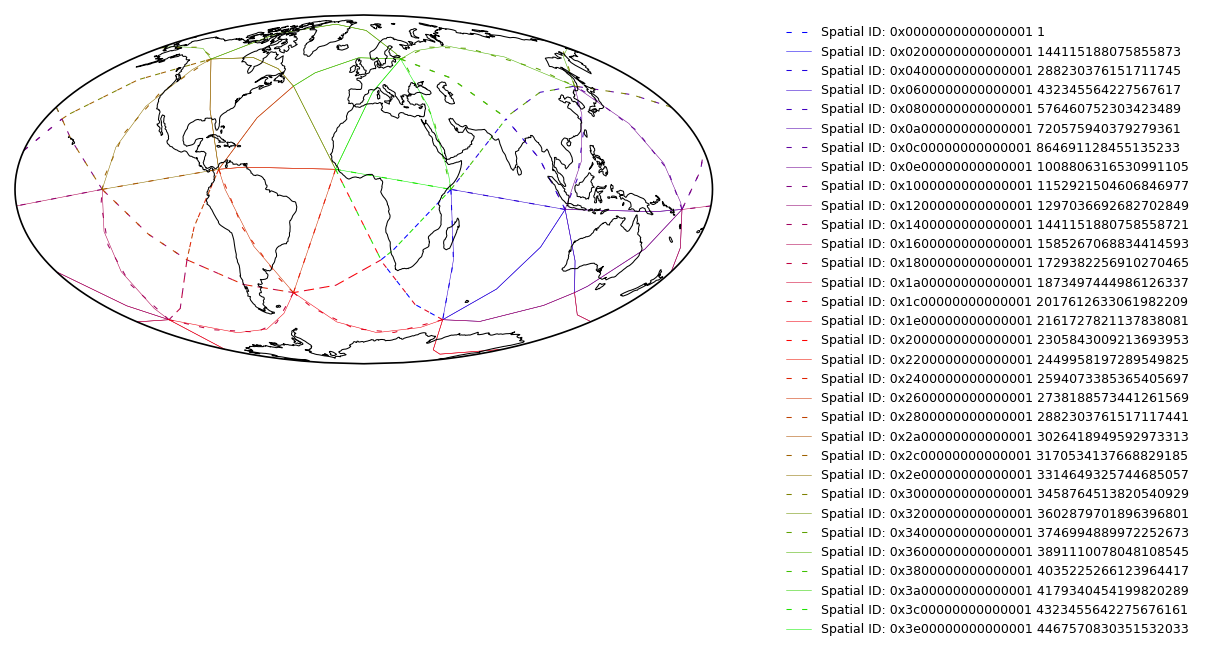

In [4]:
level = 1
level_increment = pystare.spatial_increment_from_level(level)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8*(4**level)+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, (8 * (4**level)) * level_increment, level_increment)):
    siv = siv + level # Set the level
    # print(siv_idx,siv)
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)

plt.show()
plt.close('all')
del usr_figax

In [ ]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False, 
                                      show_fig=False, plot_options=usr_plot_options))

resolution (1000.000000 km) ~ level = 3, (float 3.356144)
(lon,lat)=(-155.602778,19.479444) -> spatial_id = 0x2c2401f47797ec43

Full spatial id:              0x2c2401f47797ec43
Geolocation part (bits 61-5): 0x2c2401f47797ec40
Resolution part  (bits  4-0): 0x0000000000000003


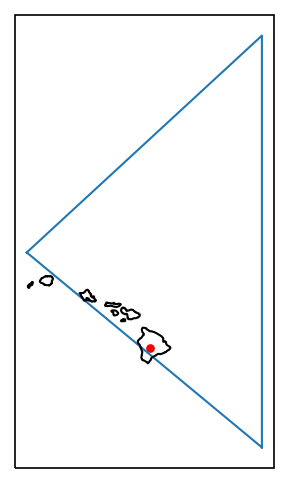

In [10]:
# Set longitude and latitude in degrees to the summit of Mauna Loa.
lon = -155.602778
lat =   19.479444

# Set the length scale of a neighborhood triangular element (trixel) about the location.
resolution_scale_km = 1000*km

# Determine the resolution, i.e. the level of the spatial quadtree, of that length scale.
spatial_resolution_level = int(pystare.spatial_resolution_from_km(resolution_scale_km))

# Calculate the spatial index value.
spatial_id = pystare.from_latlon([lat],[lon],spatial_resolution_level)

# Print to check.
print('resolution (%f km) ~ level = %i, (float %f)'%(resolution_scale_km
                                          ,spatial_resolution_level
                                          ,pystare.spatial_resolution_from_km(resolution_scale_km)))
print('(lon,lat)=(%f,%f) -> spatial_id = %s'%(lon,lat,hex16(spatial_id[0])))
print()
print('Full spatial id:              %s'%(hex16(spatial_id[0])))
print('Geolocation part (bits 61-5): %s'%(hex16(spatial_id[0] & (~31))))
print('Resolution part  (bits  4-0): %s'%(hex16(spatial_id[0] & ( 31))))

# Plot the trixel associated with the spatial index value
usr_figax = hello_plot(spatial_id,show_fig=False)
# usr_figax = add_coastlines(figax_container(plt.subplots(subplot_kw={'projection':proj,'transform':transf})))

# Plot the geolocation (lon,lat) as a red dot.
usr_figax.ax.scatter([lon],[lat],s=10,c='r')
plt.show()
del usr_figax

In [14]:
pystare.to_latlon(spatial_id)

(array([19.47944371]), array([204.39722202]))

In [16]:
lons, lats, intmat = pystare.triangulate_indices(spatial_id)

In [22]:
def make_cyclic(a):
    r = numpy.zeros(len(a)+1,dtype=a.dtype)
    r[:-1]=a; r[-1]=a[0]
    return r

In [25]:
make_cyclic(numpy.array([1,2,3]))

array([1, 2, 3, 1])

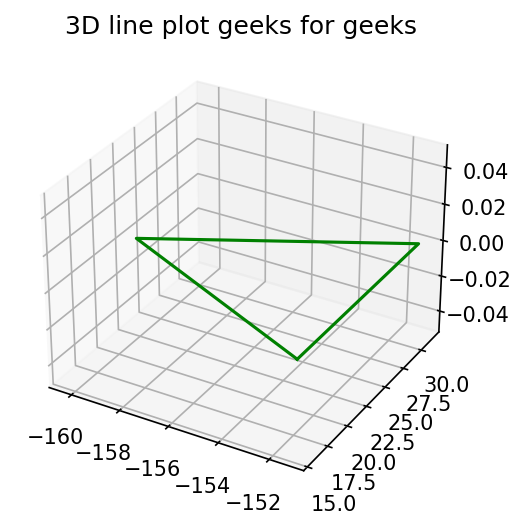

In [26]:
fig = plt.figure() 
  
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 
  
# defining all 3 axes 
z = 0.0
x = make_cyclic(lons)
y = make_cyclic(lats)
  
# plotting 
ax.plot3D(x, y, z, 'green') 
ax.set_title('3D line plot geeks for geeks') 
plt.show() 